In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib

csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["contrat_fini"] = (csv["sortie"] == max(csv["sortie"]))

In [3]:
csv

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_api_RC,url_institution,entree,sortie,nombredejours,contrat_fini
0,Sophie Errante,Errante,Sophie,F,M. Tristan Boursicot,Tristan,Boursicot,H,https://www.nosdeputes.fr/sophie-errante/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,True
1,Béatrice Piron,Piron,Béatrice,F,Mme Nadia Laid,Laid,Nadia,F,https://www.nosdeputes.fr/beatrice-piron/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-11-06 02:15:21,2018-06-28 22:00:00,234.0,True
2,Olivier Becht,Becht,Olivier,H,Mme Mariella Ceriani,Mariella,Ceriani,F,https://www.nosdeputes.fr/olivier-becht/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,True
3,Sandrine Josso,Josso,Sandrine,F,Mme Florence Sey,Sey,Florence,F,https://www.nosdeputes.fr/sandrine-josso/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2018-06-21 01:15:33,2018-06-28 22:00:00,7.0,True
4,Emmanuel Maquet,Maquet,Emmanuel,H,M. Alexis Reichert,Reichert,Alexis,H,https://www.nosdeputes.fr/emmanuel-maquet/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-08-09 01:15:51,2018-06-28 22:00:00,323.0,True
5,Coralie Dubost,Dubost,Coralie,F,Mme Chloé Mathieu,Mathieu,Chloé,F,https://www.nosdeputes.fr/coralie-dubost/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-08-13 01:15:30,2017-09-05 01:15:23,22.0,False
6,Marie-Christine Verdier-Jouclas,Verdier-Jouclas,Marie-Christine,F,Mme Chantal Louis-Williatte,Louis-Williatte,Chantal,F,https://www.nosdeputes.fr/marie-christine-verd...,http://www2.assemblee-nationale.fr/deputes/fic...,2017-11-12 02:15:28,2018-06-28 22:00:00,228.0,True
7,Guillaume Gouffier-Cha,Gouffier-Cha,Guillaume,H,Mme Paula Doumerg,Doumerg,Paula,F,https://www.nosdeputes.fr/guillaume-gouffier-c...,http://www2.assemblee-nationale.fr/deputes/fic...,2017-08-10 01:15:38,2018-06-28 22:00:00,322.0,True
8,Jean-Philippe Ardouin,Ardouin,Jean-Philippe,H,M. xc9mile Lusignan,Lusignan,xc9mile,H,https://www.nosdeputes.fr/jean-philippe-ardoui...,http://www2.assemblee-nationale.fr/deputes/fic...,2018-06-13 01:15:30,2018-06-15 01:15:32,2.0,False
9,Charles de Courson,Courson (de),Charles,H,Mme Catherine Marchand,Catherine,Marchand,F,https://www.nosdeputes.fr/charles-de-courson/xml,http://www2.assemblee-nationale.fr/deputes/fic...,2017-07-22 13:01:40,2018-06-28 22:00:00,341.0,True


In [4]:
nb_collaborateurs = csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"})

In [5]:
duree_moy_collaborateurs = csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "duree_moyenne"})

In [6]:
duree_moy_collaborateurs.sort_values("duree_moyenne", ascending=True)

,duree_moyenne
parlementaire,
Elise Fajgeles,30.000000
Nicole Dubre-Chirat,30.250000
Manuéla Kéclard-Mondésir,51.333333
Antoine Savignat,53.500000
Sylvain Brial,54.000000
Patrick Vignal,70.142857
Anissa Khedher,70.333333
Valérie Rabault,74.454545
Sonia Krimi,74.615385


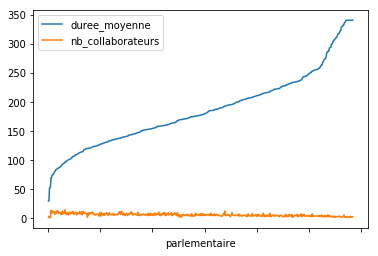

In [9]:
duree_moy_collaborateurs.merge(nb_collaborateurs, on="parlementaire").sort_values("duree_moyenne").plot()